In [31]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, fixed
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import math
import numpy as np
from plotly.graph_objs import *

In [32]:
def run_method(a, b, c, d):
    size = len(a)
    p, q = [], []
    p.append(-c[0] / b[0])
    q.append(d[0] / b[0])

    for i in range(1, size):
        pTmp = -c[i] / (b[i] + a[i] * p[i - 1])
        qTmp = (d[i] - a[i] * q[i - 1]) / (b[i] + a[i] * p[i - 1])
        p.append(pTmp)
        q.append(qTmp)

    x = [0 for _ in range(size)]
    x[size - 1] = q[size - 1]

    for i in range(size - 2, -1, -1):
        x[i] = p[i] * x[i + 1] + q[i]

    return x

class Solver:
	def __init__(self, args):
		for name, value in args.items():
			setattr(self, name, value)
		self.hx = 0
		self.hy = 0
		self.tau = 0
		try:
			self.solve_func = getattr(self, args['algorithm'])
		except:
			raise Exception("This type does not exist")

	def solve(self, nx, ny, T, K):
		self.hx = self.dx / nx
		self.hy = self.dy / ny
		self.tau = T / K

		x = np.arange(0, self.dx + self.hx, self.hx)
		y = np.arange(0, self.dy + self.hy, self.hy)
		t = np.arange(0, T + self.tau, self.tau)

		uu = np.zeros((len(x), len(y), len(t)))
		for i in range(len(x)):
			for j in range(len(y)):
				uu[i][j][0] = self.Psi(x[i], y[j])

		return self.solve_func(x, y, t, uu)

	def analytic_solve(self, nx, ny, T, K):
		self.hx = self.dx / nx
		self.hy = self.dy / ny
		self.tau = T / K
		x = np.arange(0, self.dx + self.hx, self.hx)
		y = np.arange(0, self.dy + self.hy, self.hy)
		t = np.arange(0, T + self.tau, self.tau)

		uu = np.zeros((len(x), len(y), len(t)))

		for i in range(len(x)):
			for j in range(len(y)):
				for k in range(len(t)):
					uu[i][j][k] = self.AnaliticalSolution(x[i], y[j], t[k])

		return uu

	def VariableDirections(self, x, y, t, uu):
		for k in range(1, len(t)):
			u1 = np.zeros((len(x), len(y)))
			t2 = t[k] - self.tau / 2
			for j in range(len(y) - 1):
				aa = np.zeros(len(x))
				bb = np.zeros(len(x))
				cc = np.zeros(len(x))
				dd = np.zeros(len(x))

				bb[0] = self.hx * self.alpha2 - self.alpha1
				bb[-1] = self.hx * self.beta2 + self.beta1
				cc[0] = self.alpha1
				aa[-1] = -self.beta1
				dd[0] = self.Phi11(y[j], t2) * self.hx
				dd[-1] = self.Phi12(y[j], t2) * self.hx
				for i in range(len(x) - 1):
					aa[i] = self.a - self.hx * self.c / 2
					bb[i] = self.hx ** 2 - 2 * (self.hx ** 2) / self.tau - 2 * self.a
					cc[i] = self.a + self.hx * self.c / 2
					dd[i] = -2 * (self.hx ** 2) * uu[i][j][k - 1] / self.tau
					- self.b * (self.hx ** 2) * (uu[i][j + 1][k - 1]
													  - 2 * uu[i][j][k - 1] + uu[i][j - 1][k - 1]) / (self.hy ** 2)
					- self.d * (self.hx ** 2) * (uu[i][j + 1][k - 1] - uu[i][j - 1][k - 1]) / (2 * self.hy ** 2)
					- (self.hx ** 2) * self.Function(x[i], y[j], t[k])

				xx = run_method(aa, bb, cc, dd)
				for i in range(len(x)):
					u1[i][j] = xx[i]
					u1[i][0] = (self.Phi21(x[i], t2) - self.gamma1 * u1[i][1] / self.hy) / (
							self.gamma2 - self.gamma1 / self.hy)
					u1[i][-1] = (self.Phi22(x[i], t2) + self.delta1 * u1[i][-2] / self.hy) / (
							self.delta2 + self.delta1 / self.hy)
			for j in range(len(y)):
				u1[0][j] = (self.Phi11(y[j], t2) - self.alpha1 * u1[1][j] / self.hx) / (
							self.alpha2 - self.alpha1 / self.hx)
				u1[-1][j] = (self.Phi12(y[j], t2) + self.beta1 * u1[-2][j] / self.hx) / (
							self.beta2 + self.beta1 / self.hx)
			####
			u2 = np.zeros((len(x), len(y)))
			for i in range(len(x) - 1):
				aa = np.zeros(len(x))
				bb = np.zeros(len(x))
				cc = np.zeros(len(x))
				dd = np.zeros(len(x))

				bb[0] = self.hy * self.gamma2 - self.gamma1
				bb[-1] = self.hy * self.delta2 + self.delta1
				cc[0] = self.gamma1
				aa[-1] = -self.delta1
				dd[0] = self.Phi21(x[i], t[k]) * self.hy
				dd[-1] = self.Phi22(x[i], t[k]) * self.hy

				for j in range(len(y) - 1):
					aa[j] = self.b - self.hy * self.d / 2
					bb[j] = self.hy ** 2 - 2 * (self.hy ** 2) / self.tau - 2 * self.b
					cc[j] = self.b + self.hy * self.d / 2
					dd[j] = -2 * (self.hy ** 2) * u1[i][j] / self.tau
					- self.a * (self.hy ** 2) * (u1[i + 1][j]
													  - 2 * u1[i][j] + u1[i - 1][j]) / (self.hx ** 2)
					- self.c * (self.hy ** 2) * (u1[i + 1][j] - u1[i - 1][j]) / (2 * self.hx ** 2)
					- (self.hy ** 2) * self.Function(x[i], y[j], t[k])
				xx = run_method(aa, bb, cc, dd)
				for j in range(len(y)):
					u2[i][j] = xx[j]
					u2[0][j] = (self.Phi11(y[j], t[k]) - self.alpha1 * u2[1][j] / self.hx) / (
								self.alpha2 - self.alpha1 / self.hx)
					u2[-1][j] = (self.Phi12(y[j], t[k]) + self.beta1 * u2[-2][j] / self.hx) / (
								self.beta2 + self.beta1 / self.hx)
			for i in range(len(x)):
				u2[i][0] = (self.Phi21(x[i], t[k]) - self.gamma1 * u2[i][1] / self.hy) / (
							self.gamma2 - self.gamma1 / self.hy)
				u2[i][-1] = (self.Phi22(x[i], t[k]) + self.delta1 * u2[i][-2] / self.hy) / (
							self.delta2 + self.delta1 / self.hy)
			for i in range(len(x)):
				for j in range(len(y)):
					uu[i][j][k] = u2[i][j]
		return uu

	def FractionalSteps(self, x, y, t, uu):
		for k in range(len(t)):
			u1 = np.zeros((len(x), len(y)))
			t2 = t[k] - self.tau / 2
			for j in range(len(y) - 1):
				aa = np.zeros(len(x))
				bb = np.zeros(len(x))
				cc = np.zeros(len(x))
				dd = np.zeros(len(x))

				bb[0] = self.hx * self.alpha2 - self.alpha1
				bb[-1] = self.hx * self.beta2 + self.beta1
				cc[0] = self.alpha1
				aa[-1] = -self.beta1
				dd[0] = self.Phi11(y[j], t2) * self.hx
				dd[-1] = self.Phi12(y[j], t2) * self.hx
				for i in range(len(x) - 1):
					aa[i] = self.a
					bb[i] = -(self.hx ** 2) / self.tau - 2 * self.a
					cc[i] = self.a
					dd[i] = -(self.hx ** 2) * uu[i][j][k - 1] / self.tau - (self.hx ** 2) * self.Function(x[i], y[j],
																										t2) / 2
				xx = run_method(aa, bb, cc, dd)
				for i in range(len(x)):
					u1[i][j] = xx[i]
					u1[i][0] = (self.Phi21(x[i], t2) - self.gamma1 * u1[i][1] / self.hy) / (
							self.gamma2 - self.gamma1 / self.hy)
					u1[i][-1] = (self.Phi22(x[i], t2) + self.delta1 * u1[i][-2] / self.hy) / (
							self.delta2 + self.delta1 / self.hy)
			for j in range(len(y)):
				u1[0][j] = (self.Phi11(y[j], t2) - self.alpha1 * u1[1][j] / self.hx) / (
						self.alpha2 - self.alpha1 / self.hx)
				u1[-1][j] = (self.Phi12(y[j], t2) + self.beta1 * u1[-2][j] / self.hx) / (
						self.beta2 + self.beta1 / self.hx)
			#####
			u2 = np.zeros((len(x), len(y)))
			for i in range(len(x) - 1):
				aa = np.zeros(len(x))
				bb = np.zeros(len(x))
				cc = np.zeros(len(x))
				dd = np.zeros(len(x))

				bb[0] = self.hy * self.gamma2 - self.gamma1
				bb[-1] = self.hy * self.delta2 + self.delta1
				cc[0] = self.gamma1
				aa[-1] = -self.delta1
				dd[0] = self.Phi21(x[i], t[k]) * self.hy
				dd[-1] = self.Phi22(x[i], t[k]) * self.hy

				for j in range(len(y) - 1):
					aa[j] = self.b
					bb[j] = -(self.hy ** 2) / self.tau - 2 * self.b
					cc[j] = self.b
					dd[j] = -(self.hy ** 2) * u1[i][j] / self.tau - (self.hy ** 2) * self.Function(x[i], y[j], t[k]) / 2
				xx = run_method(aa, bb, cc, dd)
				for j in range(len(y)):
					u2[i][j] = xx[j]
					u2[0][j] = (self.Phi11(y[j], t[k]) - self.alpha1 * u2[1][j] / self.hx) / (
							self.alpha2 - self.alpha1 / self.hx)
					u2[-1][j] = (self.Phi12(y[j], t[k]) + self.beta1 * u2[-2][j] / self.hx) / (
							self.beta2 + self.beta1 / self.hx)
			for i in range(len(x)):
				u2[i][0] = (self.Phi21(x[i], t[k]) - self.gamma1 * u2[i][1] / self.hy) / (
						self.gamma2 - self.gamma1 / self.hy)
				u2[i][-1] = (self.Phi22(x[i], t[k]) + self.delta1 * u2[i][-2] / self.hy) / (
						self.delta2 + self.delta1 / self.hy)
			for i in range(len(x)):
				for j in range(len(y)):
					uu[i][j][k] = u2[i][j]
		return uu

def approximate(x_list, y, t, numerical_ans):
	res = []
	for i in range(len(x_list)):
		res.append(numerical_ans[0][i][y][t])
	return res

def prepare_numerical(x, y, time, numerical_ans):
	return [approximate(x, y, time, numerical_ans) for _ in range(len(x))]

def prepare_analitycal(x_list, y, t, analytical_ans):
	res = []
	for xi in x_list:
		res.append(xi * y * np.cos(t))
	return res

def psi_0(x, t):
    return 0.0

def psi_1(x, t):
    return x * math.cos(t)

def phi_0(y, t):
    return 0.0

def phi_1(y, t):
    return y * math.cos(t)

def u0(x, y):
    return x*y

def u(x, y, t):
    return x*y * math.cos(t)

class Schema:
	def __init__(self, rho=u0, psi0=psi_0, psi1=psi_1, phi0=phi_0, phi1=phi_1,
				 lx0=0, lx1=1.0, ly0=0, ly1=1.0, T=3, order2nd=True):
		self.psi0 = psi0
		self.psi1 = psi1
		self.phi0 = phi0
		self.phi1 = phi1
		self.rho0 = rho
		self.T = T
		self.lx0 = lx0
		self.lx1 = lx1
		self.ly0 = ly0
		self.ly1 = ly1
		self.tau = None
		self.hx = None
		self.hy = None
		self.order = order2nd
		self.Nx = None
		self.Ny = None
		self.K = None
		self.cx = None
		self.bx = None
		self.cy = None
		self.by = None
		self.hx2 = None
		self.hy2 = None

	def set_l0_l1(self, lx0, lx1, ly0, ly1):
		self.lx0 = lx0
		self.lx1 = lx1
		self.ly0 = ly0
		self.ly1 = ly1

	def set_T(self, T):
		self.T = T

	def calculate_h(self):
		self.hx = (self.lx1 - self.lx0) / (self.Nx - 1)
		self.hy = (self.ly1 - self.ly0) / (self.Ny - 1)
		self.hx2 = self.hx * self.hx
		self.hy2 = self.hy * self.hy

	def calculate_tau(self):
		self.tau = self.T / (self.K - 1)

	@staticmethod
	def race_method(A, b):
		P = [-item[2] for item in A]
		Q = [item for item in b]
		P[0] /= A[0][1]
		Q[0] /= A[0][1]
		for i in range(1, len(b)):
			z = (A[i][1] + A[i][0] * P[i - 1])
			P[i] /= z
			Q[i] -= A[i][0] * Q[i - 1]
			Q[i] /= z
		for i in range(len(Q) - 2, -1, -1):
			Q[i] += P[i] * Q[i + 1]
		return Q

	@staticmethod
	def nparange(start, end, step=1):
		now = start
		e = 0.00000000001
		while now - e <= end:
			yield now
			now += step

	def calculate_left_edge(self, X, Y, t, square):
		for i in range(self.Ny):
			square[i][0] = self.phi0(Y[i][0], t)

	def calculate_right_edge(self, X, Y, t, square):
		for i in range(self.Ny):
			square[i][-1] = self.phi1(Y[i][-1], t)

	def calculate_bottom_edge(self, X, Y, t, square):
		for j in range(1, self.Nx - 1):
			square[0][j] = self.psi0(X[0][j], t)

	def calculate_top_edge(self, X, Y, t, square):
		for j in range(1, self.Nx - 1):
			square[-1][j] = self.psi1(X[-1][j], t)

	def calculate_first_step(self, i, X, Y, t, last_square, now_square):
		hy2 = self.hy2
		hx2 = self.hx2
		b = self.bx
		c = self.cx
		A = [(0, b, c)]
		w = [
			-self.cy * self.order * last_square[i - 1][1] -
			((self.order + 1) * hx2 * hy2 - 2 * self.cy * self.order) * last_square[i][1] -
			self.cy * self.order * last_square[i + 1][1] +
			self.tau * hy2 * hx2 * X[i][1] * Y[i][1] * math.sin(t) -
			c * now_square[i][0]
		]
		A.extend([(c, b, c) for _ in range(2, self.Nx - 2)])
		w.extend([
			-self.cy * self.order * last_square[i - 1][j] -
			((self.order + 1) * hx2 * hy2 - 2 * self.cy * self.order) * last_square[i][j] -
			self.cy * self.order * last_square[i + 1][j] +
			self.tau * hy2 * hx2 * X[i][j] * Y[i][j] * math.sin(t)
			for j in range(2, self.Nx - 2)
		])
		A.append((c, b, 0))
		w.append(
			-self.cy * self.order * last_square[i - 1][-2] -
			((self.order + 1) * hx2 * hy2 - 2 * self.cy * self.order) * last_square[i][-2] -
			self.cy * self.order * last_square[i + 1][-2] +
			self.tau * hy2 * hx2 * X[i][-2] * Y[i][-2] * math.sin(t) -
			c * now_square[i][-1]
		)
		line = self.race_method(A, w)
		for j in range(1, self.Nx - 1):
			now_square[i][j] = line[j - 1]

	def calculate_second_step(self, j, X, Y, t, last_square, now_square):
		hx2 = self.hx2
		hy2 = self.hy2
		c = self.cy
		b = self.by
		A = [(0, b, c)]
		w = [
			-self.cx * self.order * last_square[1][j - 1] -
			((self.order + 1) * hx2 * hy2 - 2 * self.cx * self.order) * last_square[1][j] -
			self.cx * self.order * last_square[1][j + 1] +
			self.tau * hy2 * hx2 * X[1][j] * Y[1][j] * math.sin(t) -
			c * now_square[0][j]
		]
		A.extend([(c, b, c) for _ in range(2, self.Ny - 2)])
		w.extend([
			-self.cx * self.order * last_square[i][j - 1] -
			((self.order + 1) * hx2 * hy2 - 2 * self.cx * self.order) * last_square[i][j] -
			self.cx * self.order * last_square[i][j + 1] +
			self.tau * hy2 * hx2 * X[i][j] * Y[i][j] * math.sin(t)
			for i in range(2, self.Ny - 2)
		])
		A.append((c, b, 0))
		w.append(
			-self.cx * self.order * last_square[-2][j - 1] -
			((self.order + 1) * hx2 * hy2 - 2 * self.cx * self.order) * last_square[-2][j] -
			self.cx * self.order * last_square[-2][j + 1] +
			self.tau * hy2 * hx2 * X[-2][j] * Y[-2][j] * math.sin(t) -
			c * now_square[-1][j]
		)
		line = self.race_method(A, w)
		for i in range(1, self.Ny - 1):
			now_square[i][j] = line[i - 1]

	def calculate_square(self, X, Y, t, last_square):
		square = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
		self.calculate_left_edge(X, Y, t - 0.5 * self.tau, square)
		self.calculate_right_edge(X, Y, t - 0.5 * self.tau, square)
		self.calculate_bottom_edge(X, Y, t - 0.5 * self.tau, square)
		self.calculate_top_edge(X, Y, t - 0.5 * self.tau, square)
		for i in range(1, self.Ny - 1):
			self.calculate_first_step(i, X, Y, t - 0.5 * self.tau, last_square, square)
		last_square = square
		square = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
		self.calculate_left_edge(X, Y, t, square)
		self.calculate_right_edge(X, Y, t, square)
		self.calculate_bottom_edge(X, Y, t, square)
		self.calculate_top_edge(X, Y, t, square)
		for j in range(1, self.Nx - 1):
			self.calculate_second_step(j, X, Y, t, last_square, square)
		return square

	def init_t0(self, X, Y):
		first = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
		for i in range(self.Ny):
			for j in range(self.Nx):
				first[i][j] = self.rho0(X[i][j], Y[i][j])
		return first

	def __call__(self, Nx=20, Ny=20, K=20):
		self.Nx, self.Ny, self.K = Nx, Ny, K
		self.calculate_tau()
		self.calculate_h()

		self.bx = -2 * self.tau * self.hy2
		self.bx -= (1 + self.order) * self.hx2 * self.hy2
		self.cx = self.tau * self.hy2

		self.cy = self.tau * self.hx2
		self.by = -2 * self.tau * self.hx2
		self.by -= (1 + self.order) * self.hx2 * self.hy2
		x = list(self.nparange(self.lx0, self.lx1, self.hx))
		y = list(self.nparange(self.ly0, self.ly1, self.hy))
		X = [x for _ in range(self.Ny)]
		Y = [[y[i] for _ in x] for i in range(self.Ny)]

		taus = [0.0]
		ans = [self.init_t0(X, Y)]
		for t in self.nparange(self.tau, self.T, self.tau):
			ans.append(self.calculate_square(X, Y, t, ans[-1]))
			taus.append(t)
		return X, Y, taus, ans


def real_z_by_time(lx0, lx1, ly0, ly1, t, f):
    x = np.arange(lx0, lx1 + 0.002, 0.002)
    y = np.arange(ly0, ly1 + 0.002, 0.002)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j], t)
    return X, Y, Z

def count_error(X, Y, t, z, ut = u):
    ans = 0.0
    for i in range(len(z)):
        for j in  range(len(z[i])):
            ans = max(abs(ut(X[i][j], Y[i][j], t) - z[i][j]), ans)
    return (ans / len(z) / len(z[0]))

def get_step_slice(lst, step):
    return lst[step]

def animate(lst, play=False, interval=200):
    slider = widgets.IntSlider(min=0, max=len(lst) - 1, step=1, value=0)
    if play:
        play_widjet = widgets.Play(interval=interval)
        widgets.jslink((play_widjet, 'value'), (slider, 'value'))
        display(play_widjet)
    return interact(get_step_slice,
                    lst=fixed(lst),
                    step=slider)


def plot_by_time(X, Y, T, Z, j, extrems, plot_true=True):
	t = T[j]
	z = Z[j]
	fig = plt.figure(num=1, figsize=(20, 13), clear=True)
	ax = fig.add_subplot(1, 1, 1, projection='3d')
	ax.plot_surface(np.array(X), np.array(Y), np.array(z))
	if plot_true:
		ax.plot_wireframe(*real_z_by_time(0, 1, 0, 1, t, u), color="green")
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	ax.set_zlabel('z')
	ax.set_title(
		't = ' + str(round(t, 8)) + " error = " + str(round(count_error(X, Y, t, z), 11)),
		loc="right", fontsize=25
	)
	ax.set_zlim(extrems[0], extrems[1])
	fig.tight_layout()
	plt.close(fig)
	return fig


def square_min_max(z):
	minimum, maximum = z[0][0], z[0][0]
	for i in range(len(z)):
		for j in range(len(z[i])):
			minimum = z[i][j] if z[i][j] < minimum else minimum
			maximum = z[i][j] if z[i][j] > maximum else maximum
	return minimum, maximum


def search_min_max(zz):
	minimum, maximum = 0.0, 0.0
	for z in zz:
		minmax = square_min_max(z)
		minimum = minmax[0] if minmax[0] < minimum else minimum
		maximum = minmax[1] if minmax[1] > maximum else maximum
	return minimum, maximum


def animate_plot(nx=15, ny=15, k=50, t=5, plot_true=False):
	schema = Schema(T=t, order2nd=True)
	xx, yy, tt, zz = schema(Nx=nx, Ny=ny, K=k)
	extrems = search_min_max(zz)
	plots = []
	for j in range(len(tt)):
		plots.append(plot_by_time(xx, yy, tt, zz, j, extrems, plot_true))
	animate(plots, play=True, interval=2000)

first = Schema(T = 2*math.pi, order2nd = False) #метод дробных шагов
second = Schema(T = 2*math.pi, order2nd = True) #метод переменных направлений

def get_h_graph(solver, time = 0, tsteps = 40):
    h, e = [], []
    for N in range(4, 20, 1):
        x, y, t, z = solver(Nx = N, Ny = N, K = tsteps)
        h.append(solver.hx)
        e.append(count_error(x, y, t[time], z[time]))
    return h, e

TSTEPS = 100
time = random.randint(0, TSTEPS - 1)
h1, e1 = get_h_graph(first, time, TSTEPS)
h2, e2 = get_h_graph(second, time, TSTEPS)

def get_tau_graph(solver):
    tau = []
    e = []
    for K in range(15, 100, 2):
        x, y, t, z = solver(Nx = 10, Ny = 10, K = K)
        tau.append(solver.tau)
        time = K // 2
        e.append(count_error(x, y, t[time], z[time]))
    return tau, e

tau1, e1 = get_tau_graph(first)
tau2, e2 = get_tau_graph(second)

def count_full_error(X, Y, T, Z):
    ans = 0.0
    for k in range(len(T)):
        for i in range(len(X)):
            for j in range(len(X[i])):
                ans = max(abs(u(X[i][j], Y[i][j], T[k]) - Z[k][i][j]), ans)
    return (ans / len(T) / len(X) / len(X[0]))

TimeList = [random.randint(0, 40 - 1) for i in range(4)]
def plot_error_dependency(Nx=4, Ny=4, K=40, Method=0):
    NxFix = Nx
    NyFix = Ny
    if Method != 0:
        method = True
        stri = 'Погрешность метода переменных направлений'
    else:
        method = False
        stri = 'Погрешность метода дробных шагов'
    plt.figure(figsize=(6, 12))
    for i in range(1, 4):
        plt.subplot(5, 1, i)
        Time = TimeList[i-1]#random.randint(0, K - 1)
        schema = Schema(T=Time, order2nd=method)
        h, eps = [], []
        for j in range(10):
            h.append([])
            eps.append([])
            X, Y, T, Z = schema(Nx, Ny, K)
            Nx += 1
            Ny += 1
            h[-1].append(schema.hx)
            eps[-1].append(count_error(X, Y, T[Time], Z[Time]))
        Nx = NxFix
        Ny = NyFix
        plt.plot(np.array(h), np.array(eps), label="const T = " + str(round(T[Time])))
        plt.xlabel('h')
        plt.ylabel('e')
        plt.title(stri)
        plt.legend()
        plt.grid()
        plt.show()

In [33]:
firstMethod = True
nx, ny, T, K = 40, 40, 5, 100
plottingTime = 2

In [34]:
args = {
    'a': 1,
    'b': 1,
    'c': 0,
    'd': 0,
    'dx': 1,
    'dy': 1,
    'Function': lambda x, y, t: - x * y * np.sin(t),
    'alpha1': 0,
    'alpha2': 1,
    'beta1': 0,
    'beta2': 1,
    'gamma1': 0,
    'gamma2': 1,
    'delta1': 0,
    'delta2': 1,
    'Phi11': lambda y, t: 0,
    'Phi12': lambda y, t: y * np.cos(t),
    'Phi21': lambda x, t: 0,
    'Phi22': lambda x, t: x * np.cos(t),
    'Psi': lambda x, y: x * y,
    'AnaliticalSolution': lambda x, y, t: x * y * np.cos(t),
    'algorithm' : 'VariableDirections' if firstMethod else 'FractionalSteps'
}
solver = Solver(args)
numerical_ans = solver.solve(nx, ny, T, K),
analytical_ans = solver.analytic_solve(nx, ny, T, K)

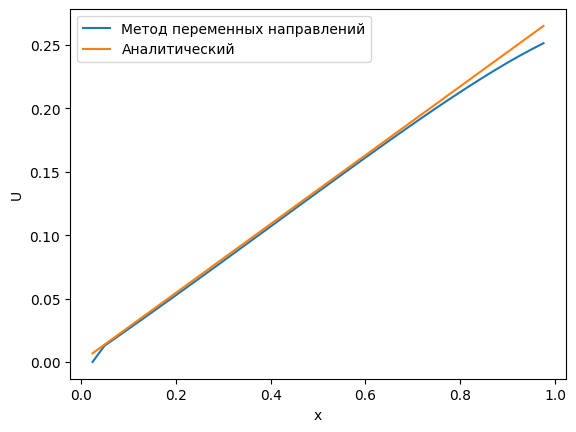

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


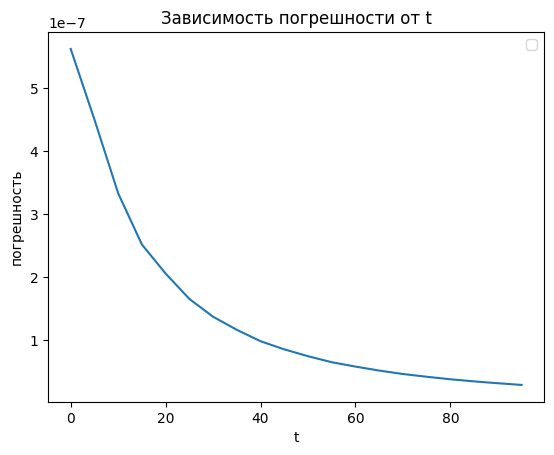

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


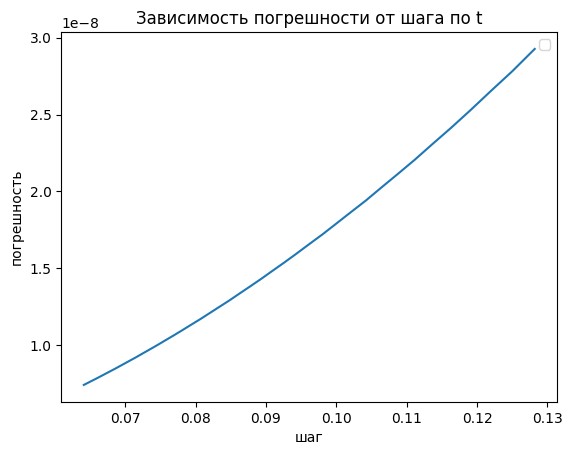

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


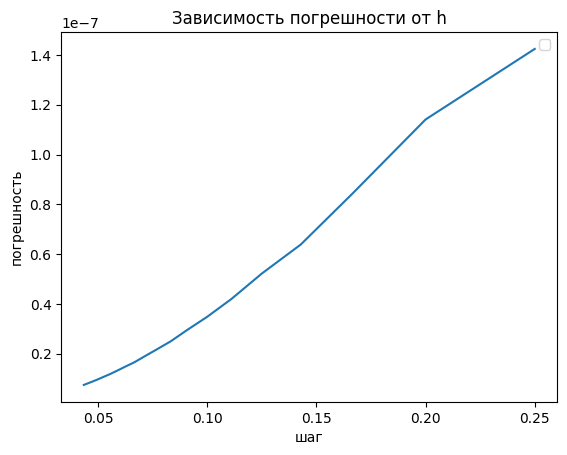

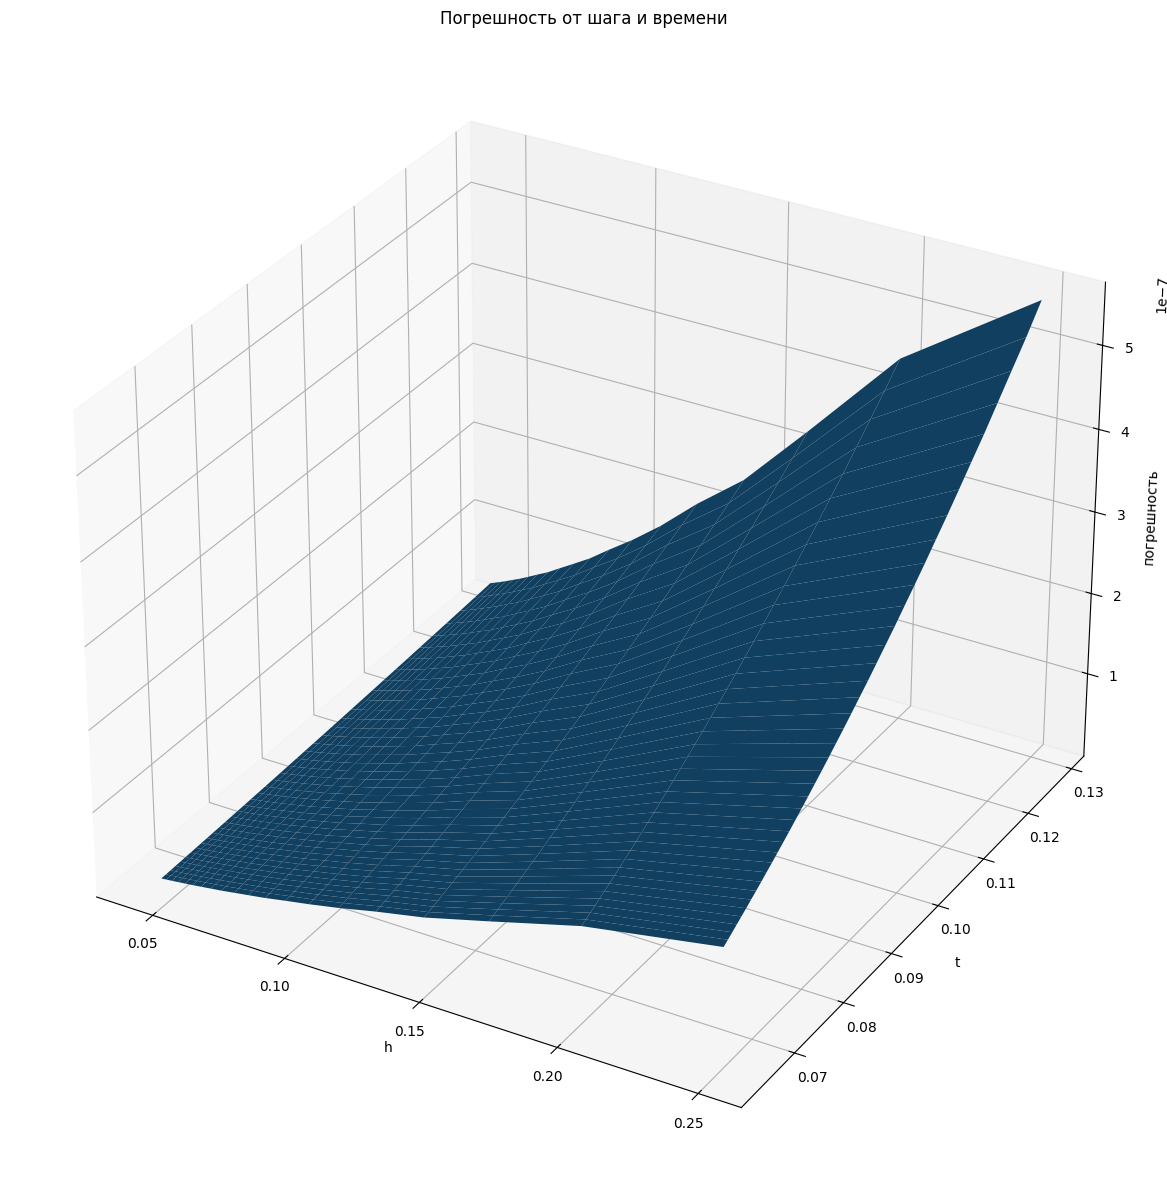

In [35]:
def draw_graphs(numerical_ans, analytical_ans, nx, ny, T, K, time, check = 0):
    fig = plt.figure()
    hx = 1 / nx
    hy = 1 / ny
    tau = T / K

    x = np.arange(hx, 1, hx)
    y = np.arange(hy, 1, hy)
    t = np.arange(tau, T, tau)


    z1 = prepare_numerical(x, 10, time, numerical_ans)
    z2 = prepare_analitycal(x, y[10], t[time], analytical_ans)

    # plt.title('U от x')
    if check == 0:
      plt.plot(x, z1[time], label='Метод переменных направлений')
    else:
      plt.plot(x, z1[time], label='Метод дробных шагов')

    plt.plot(x, z2, label='Аналитический')
    plt.legend(loc='best')
    plt.ylabel('U')
    plt.xlabel('x')
    plt.show()

    solv = Schema(T=T, order2nd=firstMethod)
    h = []
    tau = []
    eps = []
    for i in tqdm(range(20)):
        h.append([])
        tau.append([])
        eps.append([])
        for j in range(40):
            N = i + 5
            K = j + 40
            X, Y, T, Z = solv(N, N, K)
            h[-1].append(solv.hx)
            tau[-1].append(solv.tau)
            eps[-1].append(count_full_error(X, Y, T, Z))

    t = range(0, 100, 5)
    err = [max(m) for m in eps]
    fig = plt.figure()
    plt.title('Зависимость погрешности от t')
    plt.plot(t, err)
    plt.legend(loc='best')
    plt.ylabel('погрешность')
    plt.xlabel('t')
    plt.show()

    fig = plt.figure()
    plt.title('Зависимость погрешности от шага по t')
    plt.plot(tau[-1], eps[-1])
    plt.legend(loc='best')
    plt.ylabel('погрешность')
    plt.xlabel('шаг')
    plt.show()

    ee = [eps[i][-1] for i in range(len(eps))]
    hh = [h[i][-1] for i in range(len(h))]

    fig = plt.figure()
    plt.title('Зависимость погрешности от h')
    plt.plot(hh, ee)
    plt.legend(loc='best')
    plt.ylabel('погрешность')
    plt.xlabel('шаг')
    plt.show()

    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(np.array(h), np.array(tau), np.array(eps))
    ax.set(xlabel='h', ylabel='t', zlabel='погрешность', title='Погрешность от шага и времени')
    fig.tight_layout()
    return (np.array(h), np.array(tau), np.array(eps))

h, tau, eps = draw_graphs(numerical_ans, analytical_ans, nx, ny, T, K, plottingTime)

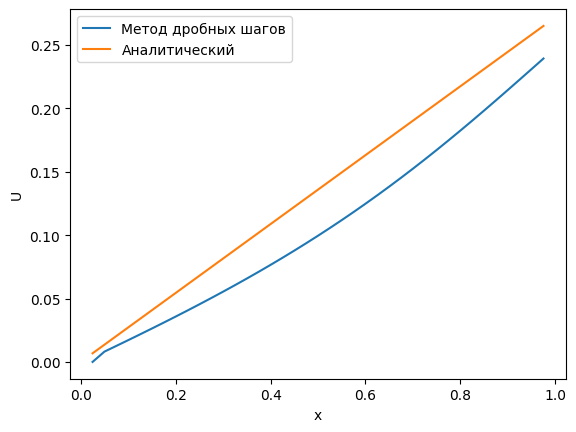

100%|██████████| 20/20 [00:21<00:00,  1.06s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


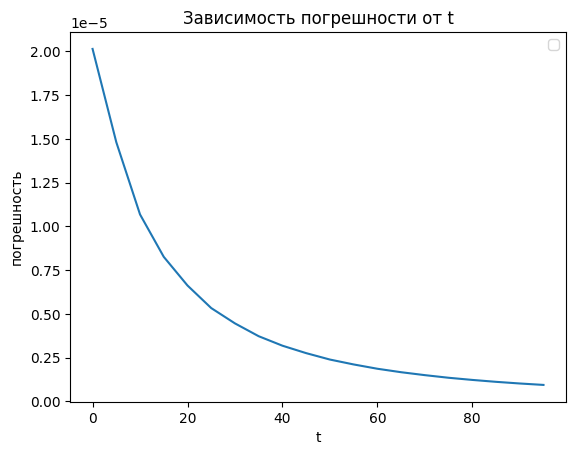

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


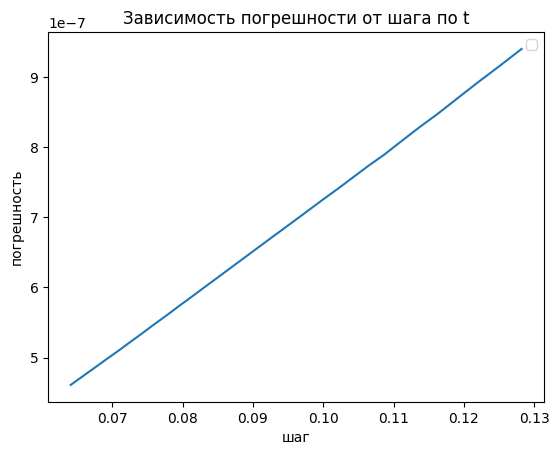

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


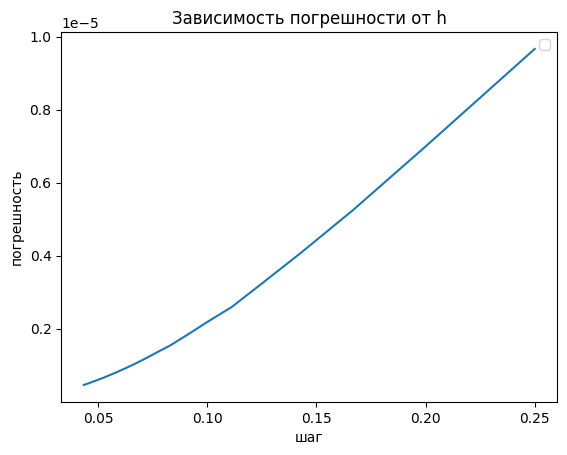

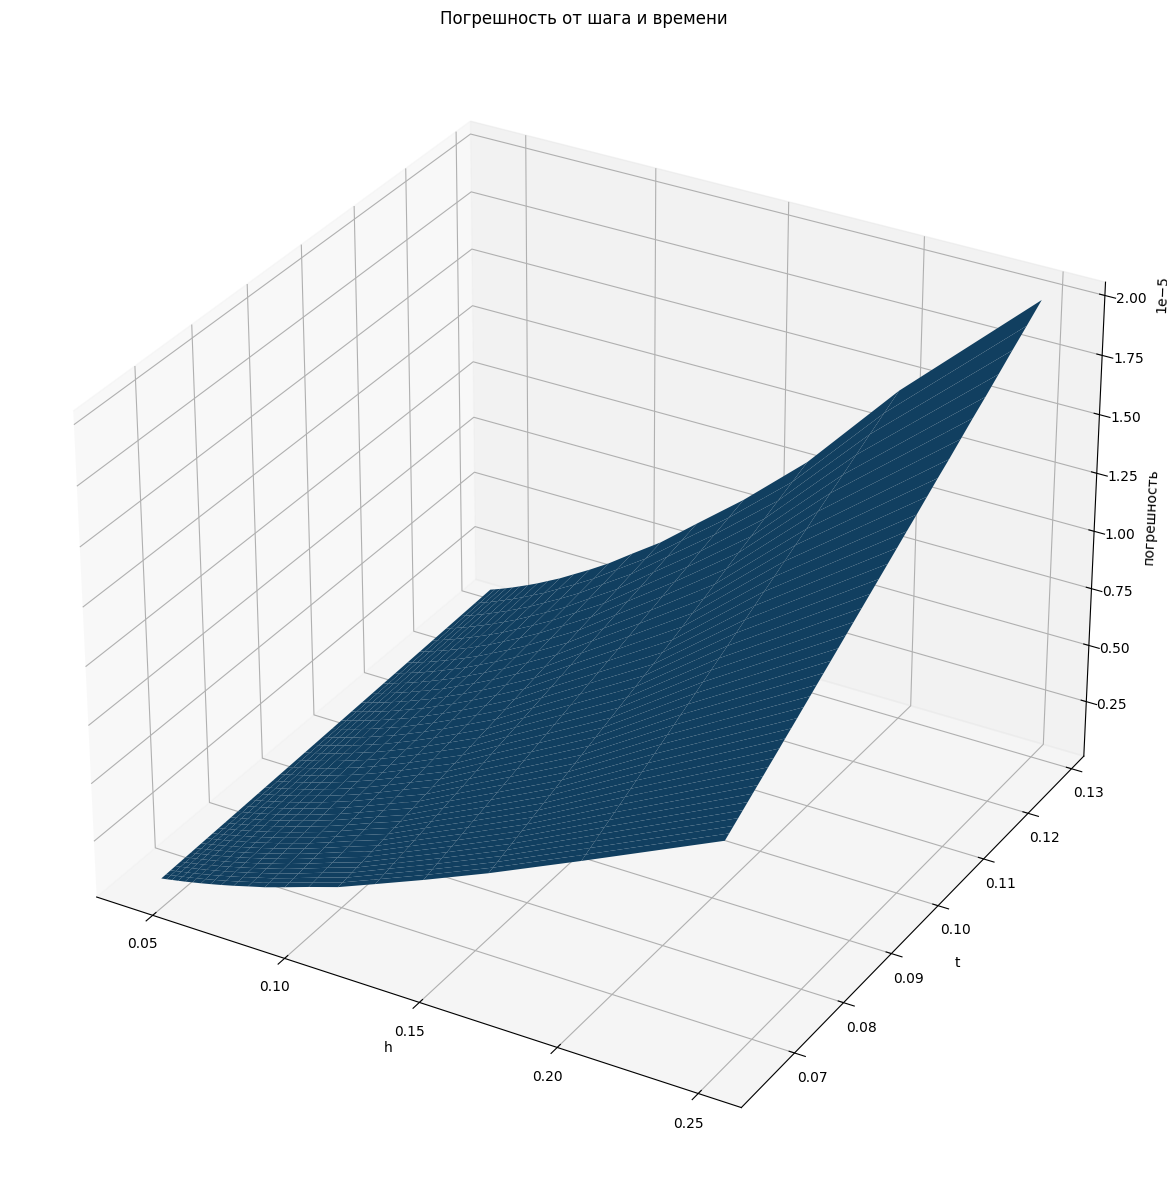

In [36]:

firstMethod = False
args['algorithm'] = 'FractionalSteps'
solver = Solver(args)
numerical_ans = solver.solve(nx, ny, T, K),
analytical_ans = solver.analytic_solve(nx, ny, T, K)

h1, tau1, eps1 = draw_graphs(numerical_ans, analytical_ans, nx, ny, T, K, plottingTime, 1)